# NFlowsRegressor: Sklearn-Compatible Normalizing Flows

This notebook demonstrates the `NFlowsRegressor` class, which provides sklearn-compatible normalizing flows for regression with both forward and inverse inference.

**Key capabilities:**
- Forward prediction with uncertainty quantification
- Inverse inference (find inputs that produce desired outputs)
- Full sklearn API: works with cross-validation, GridSearchCV, pipelines

## Contents
1. Basic Usage: 1D Regression
2. Uncertainty Quantification
3. Inverse Inference
4. Chemical Engineering Example: CSTR Design
5. Sklearn Integration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from pycse.sklearn.nflows_regressor import NFlowsRegressor, create_flow_regressor

np.random.seed(42)

## 1. Basic Usage: 1D Regression

We'll fit a nonlinear function with heteroscedastic (input-dependent) noise.

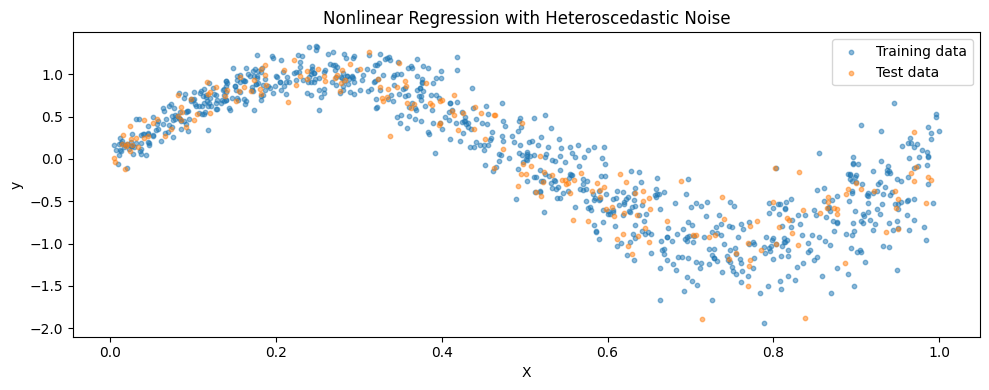

In [2]:
# Generate synthetic data: y = sin(2*pi*x) + noise that varies with x
n_samples = 1000

X = np.random.uniform(0, 1, (n_samples, 1))
noise_std = 0.1 + 0.3 * X  # Heteroscedastic noise
y = np.sin(2 * np.pi * X) + noise_std * np.random.randn(n_samples, 1)
y = y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.figure(figsize=(10, 4))
plt.scatter(X_train, y_train, alpha=0.5, s=10, label="Training data")
plt.scatter(X_test, y_test, alpha=0.5, s=10, label="Test data")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Nonlinear Regression with Heteroscedastic Noise")
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
# Fit the NFlowsRegressor
model = NFlowsRegressor(
    num_layers=5,
    hidden_features=64,
    num_bins=8,
    max_epochs=300,
    patience=30,
    verbose=True,
    random_state=42,
)

model.fit(X_train, y_train)
print(f"\nTest score (neg MSE): {model.score(X_test, y_test):.4f}")

Forward flow Epoch 50/300, Loss: 0.2885
Forward flow Epoch 100/300, Loss: 0.2100
Forward flow: Early stopping at epoch 105
Inverse flow Epoch 50/300, Loss: 0.3012
Inverse flow Epoch 100/300, Loss: 0.2721
Inverse flow: Early stopping at epoch 112

Test score (neg MSE): -0.0771


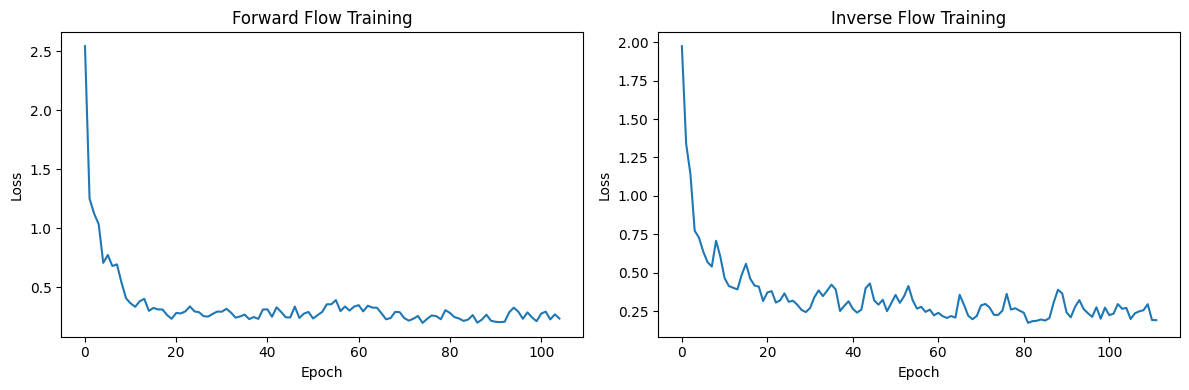

In [4]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(model.forward_losses_)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Forward Flow Training")

axes[1].plot(model.inverse_losses_)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Inverse Flow Training")

plt.tight_layout()
plt.show()

## 2. Uncertainty Quantification

Normalizing flows naturally provide uncertainty estimates by sampling from the learned distribution.

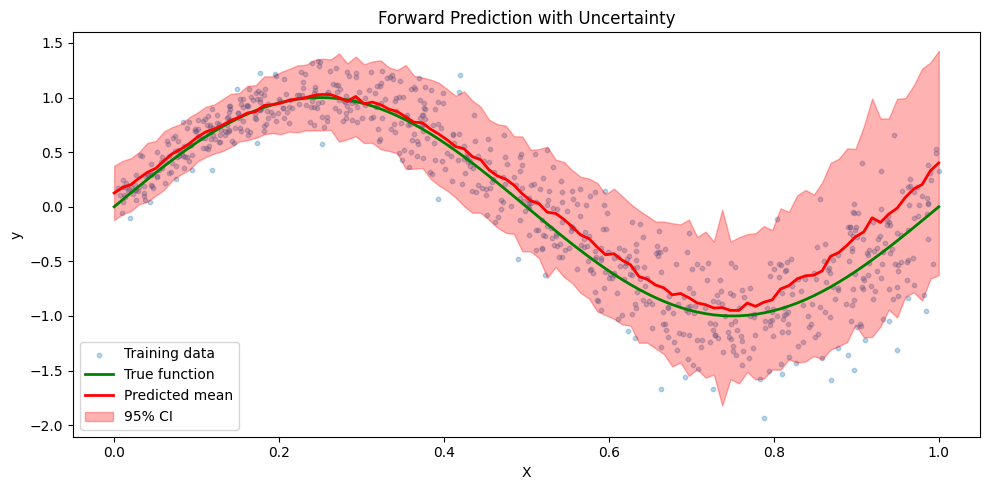

In [5]:
# Forward prediction with uncertainty
X_plot = np.linspace(0, 1, 100).reshape(-1, 1)

# Sample multiple predictions to get uncertainty
n_posterior_samples = 200
y_samples = np.array([model.predict(X_plot, n_samples=1) for _ in range(n_posterior_samples)])
y_mean = y_samples.mean(axis=0)
y_std = y_samples.std(axis=0)

# True function
y_true = np.sin(2 * np.pi * X_plot).ravel()

plt.figure(figsize=(10, 5))
plt.scatter(X_train, y_train, alpha=0.3, s=10, label="Training data")
plt.plot(X_plot, y_true, "g-", linewidth=2, label="True function")
plt.plot(X_plot, y_mean, "r-", linewidth=2, label="Predicted mean")
plt.fill_between(
    X_plot.ravel(), y_mean - 2 * y_std, y_mean + 2 * y_std, alpha=0.3, color="red", label="95% CI"
)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Forward Prediction with Uncertainty")
plt.legend()
plt.tight_layout()
plt.show()

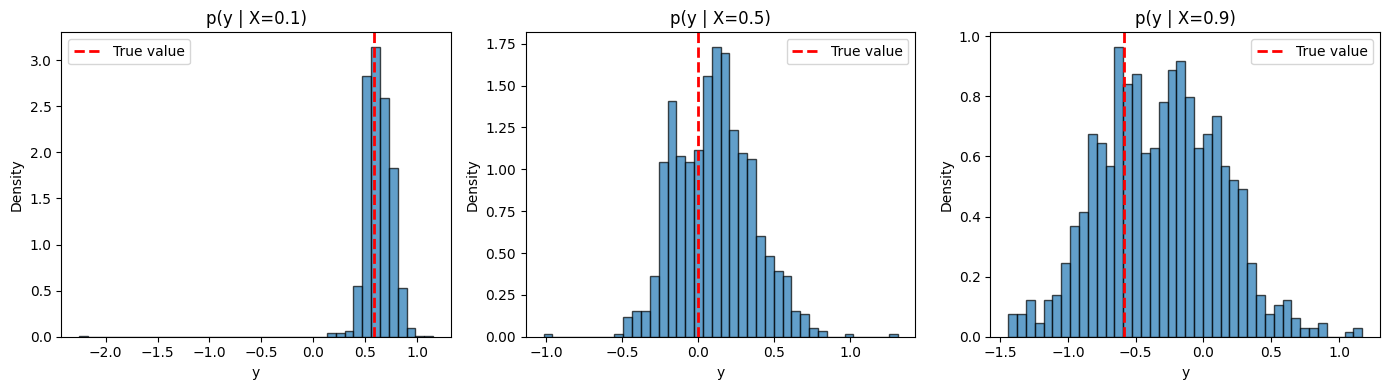

Notice how the distribution widens at higher X (heteroscedastic uncertainty)!


In [6]:
# Visualize posterior distributions at specific X values
x_values = [0.1, 0.5, 0.9]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, x_val in zip(axes, x_values):
    samples = model.sample_posterior(np.array([[x_val]]), n_samples=1000)
    ax.hist(samples.ravel(), bins=40, density=True, alpha=0.7, edgecolor="black")
    ax.axvline(
        np.sin(2 * np.pi * x_val), color="red", linestyle="--", linewidth=2, label="True value"
    )
    ax.set_xlabel("y")
    ax.set_ylabel("Density")
    ax.set_title(f"p(y | X={x_val})")
    ax.legend()

plt.tight_layout()
plt.show()

print("Notice how the distribution widens at higher X (heteroscedastic uncertainty)!")

## 3. Inverse Inference

The inverse flow allows us to answer: **"What input X would produce output y?"**

This is useful for:
- Design optimization (finding inputs for desired outputs)
- Root finding (what X gives y=0?)
- Inverse problems in general

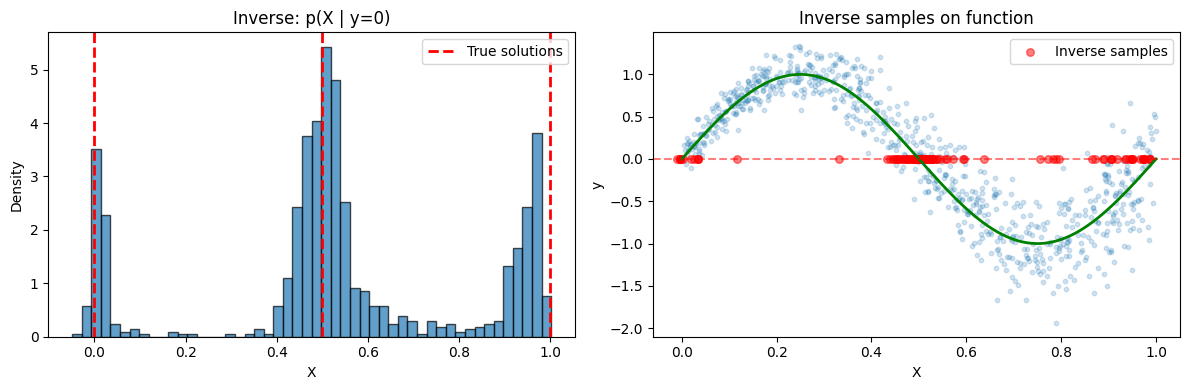

In [7]:
# Inverse inference: find X where y = 0
target_y = np.array([[0.0]])
X_inverse_samples = model.inverse(target_y, n_samples=1000)

# The true solutions are x = 0, 0.5, 1.0 for sin(2*pi*x) = 0
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of inverse samples
axes[0].hist(X_inverse_samples.ravel(), bins=50, density=True, alpha=0.7, edgecolor="black")
for x_true in [0.0, 0.5, 1.0]:
    axes[0].axvline(x_true, color="red", linestyle="--", linewidth=2)
axes[0].set_xlabel("X")
axes[0].set_ylabel("Density")
axes[0].set_title("Inverse: p(X | y=0)")
axes[0].legend(["True solutions"], loc="upper right")

# Show on the function plot
axes[1].scatter(X_train, y_train, alpha=0.2, s=10)
axes[1].plot(X_plot, y_true, "g-", linewidth=2)
axes[1].axhline(0, color="red", linestyle="--", alpha=0.5)
axes[1].scatter(
    X_inverse_samples[:100], np.zeros(100), c="red", s=30, alpha=0.5, label="Inverse samples"
)
axes[1].set_xlabel("X")
axes[1].set_ylabel("y")
axes[1].set_title("Inverse samples on function")
axes[1].legend()

plt.tight_layout()
plt.show()

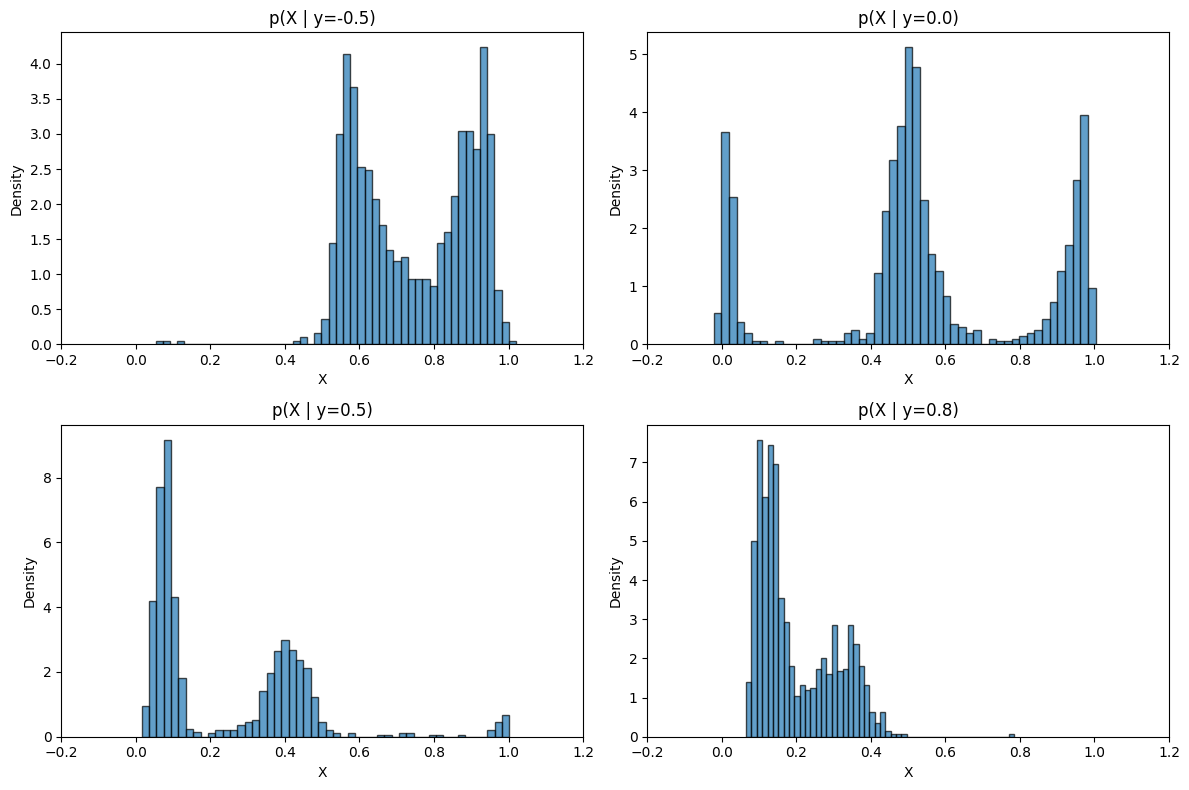

In [8]:
# Inverse inference for multiple target values
target_values = [-0.5, 0.0, 0.5, 0.8]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, target in enumerate(target_values):
    X_samples = model.inverse(np.array([[target]]), n_samples=1000)

    axes[i].hist(X_samples.ravel(), bins=50, density=True, alpha=0.7, edgecolor="black")
    axes[i].set_xlabel("X")
    axes[i].set_ylabel("Density")
    axes[i].set_title(f"p(X | y={target})")
    axes[i].set_xlim(-0.2, 1.2)

plt.tight_layout()
plt.show()

## 4. Chemical Engineering Example: CSTR Design

**Problem:** Given desired output concentrations $(C_A, C_B)$ from a CSTR, find the design parameters $(R, RT)$ that achieve them.

**Setup:**
- Fixed height CSTR, variable radius $R$ and temperature (via $RT$)
- Two reactions: $A \rightarrow B$ (2nd order), $A \rightarrow C$ (1st order)
- Rate constants: $k_1 = \exp(-3/RT)$, $k_2 = \exp(-10/RT)$

In [9]:
# CSTR forward model
H = 1.0  # Height (fixed)
v0 = 1.0  # Volumetric flow rate
Ca0 = 1.0  # Inlet concentration of A
Fa0 = v0 * Ca0


def cstr_forward(R, RT):
    """Compute outlet concentrations (Ca, Cb) given reactor design (R, RT)."""
    R = np.atleast_1d(R)
    RT = np.atleast_1d(RT)

    V = np.pi * R**2 * H
    k1 = np.exp(-3.0 / RT)  # A -> B (2nd order)
    k2 = np.exp(-10.0 / RT)  # A -> C (1st order)

    # Quadratic formula for Ca
    a = V * k1
    b = v0 + V * k2
    c = -Fa0

    Ca = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)
    Cb = k1 * Ca**2 * V / v0

    return Ca, Cb


# Generate training data
n_cstr = 3000
R_samples = np.random.uniform(0.1, 3.0, n_cstr)
RT_samples = np.random.uniform(0.1, 15.0, n_cstr)
Ca_samples, Cb_samples = cstr_forward(R_samples, RT_samples)

X_cstr = np.column_stack([R_samples, RT_samples])  # Input: (R, RT)
y_cstr = np.column_stack([Ca_samples, Cb_samples])  # Output: (Ca, Cb)

X_train_cstr, X_test_cstr, y_train_cstr, y_test_cstr = train_test_split(
    X_cstr, y_cstr, test_size=0.2, random_state=42
)

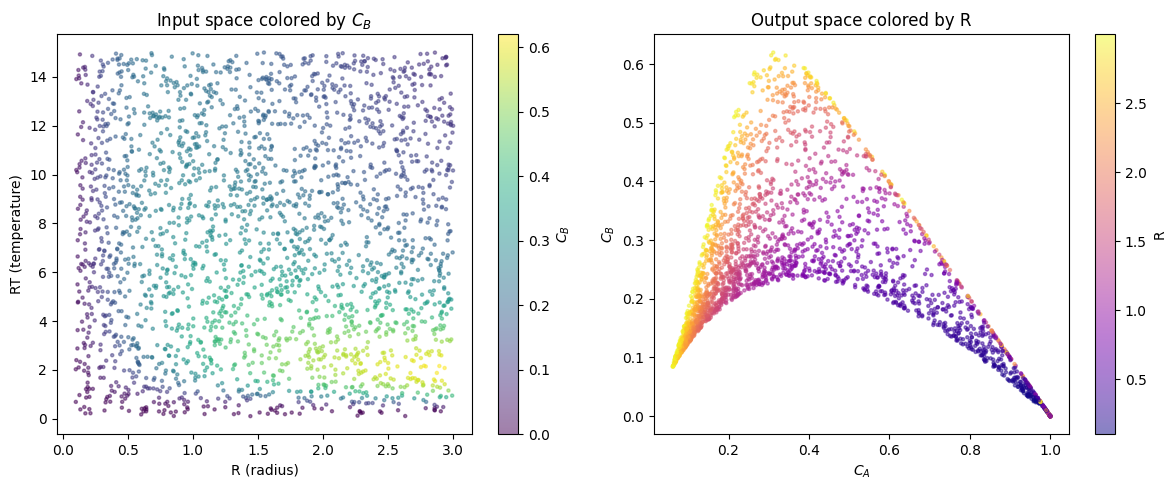

In [10]:
# Visualize the mapping
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sc1 = axes[0].scatter(
    X_train_cstr[:, 0], X_train_cstr[:, 1], c=y_train_cstr[:, 1], s=5, alpha=0.5, cmap="viridis"
)
axes[0].set_xlabel("R (radius)")
axes[0].set_ylabel("RT (temperature)")
axes[0].set_title("Input space colored by $C_B$")
plt.colorbar(sc1, ax=axes[0], label="$C_B$")

sc2 = axes[1].scatter(
    y_train_cstr[:, 0], y_train_cstr[:, 1], c=X_train_cstr[:, 0], s=5, alpha=0.5, cmap="plasma"
)
axes[1].set_xlabel("$C_A$")
axes[1].set_ylabel("$C_B$")
axes[1].set_title("Output space colored by R")
plt.colorbar(sc2, ax=axes[1], label="R")

plt.tight_layout()
plt.show()

In [11]:
# Fit model on CSTR data
model_cstr = NFlowsRegressor(
    num_layers=8, hidden_features=64, max_epochs=500, patience=30, verbose=True, random_state=42
)

model_cstr.fit(X_train_cstr, y_train_cstr)
print(f"\nTest score (neg MSE): {model_cstr.score(X_test_cstr, y_test_cstr):.6f}")

Forward flow Epoch 50/500, Loss: -3.1777
Forward flow Epoch 100/500, Loss: -4.1650
Forward flow: Early stopping at epoch 115
Inverse flow Epoch 50/500, Loss: -2.6357
Inverse flow Epoch 100/500, Loss: -4.1788
Inverse flow Epoch 150/500, Loss: -4.7289
Inverse flow: Early stopping at epoch 190

Test score (neg MSE): -0.000093


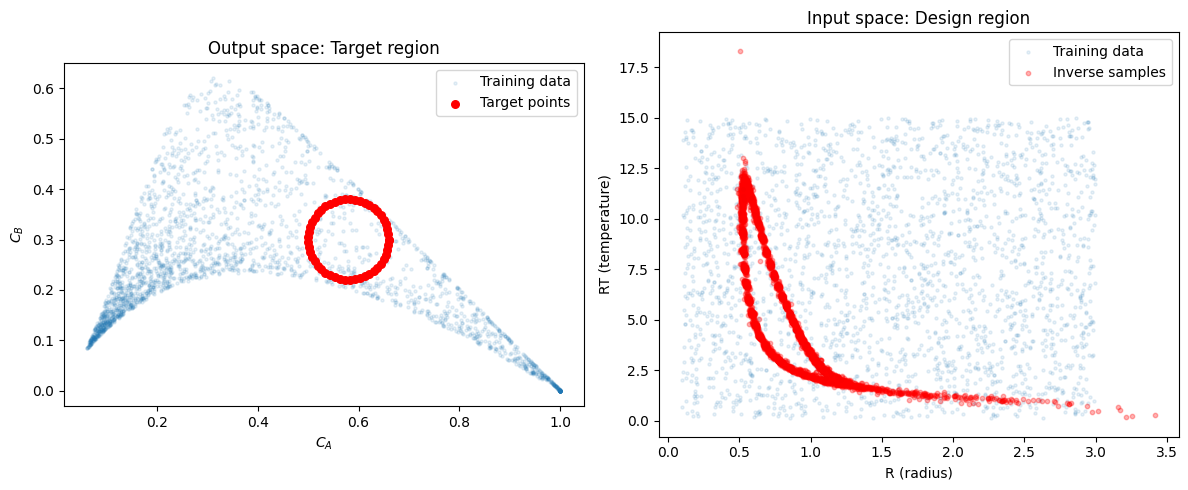

Fraction of inverse samples mapping near target: 99.5%


In [12]:
# Inverse problem: Find (R, RT) for a target concentration region
target_center = np.array([0.58, 0.3])
target_radius = 0.08

# Generate points around the target
n_target = 50
theta_circle = np.linspace(0, 2 * np.pi, n_target)
target_Ca = target_center[0] + target_radius * np.cos(theta_circle)
target_Cb = target_center[1] + target_radius * np.sin(theta_circle)
target_points = np.column_stack([target_Ca, target_Cb])

# Use inverse flow to find (R, RT) for each target point
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Output space with target region
axes[0].scatter(y_train_cstr[:, 0], y_train_cstr[:, 1], alpha=0.1, s=5, label="Training data")
circle = plt.Circle(target_center, target_radius, fill=False, color="red", linewidth=2)
axes[0].add_patch(circle)
axes[0].scatter(target_Ca, target_Cb, c="red", s=30, label="Target points")
axes[0].set_xlabel("$C_A$")
axes[0].set_ylabel("$C_B$")
axes[0].set_title("Output space: Target region")
axes[0].legend()
axes[0].set_aspect("equal")

# Sample from inverse distribution for each target
all_R_samples = []
all_RT_samples = []

for target in target_points:
    X_inv = model_cstr.inverse(target.reshape(1, -1), n_samples=100)
    all_R_samples.extend(X_inv[:, 0])
    all_RT_samples.extend(X_inv[:, 1])

all_R_samples = np.array(all_R_samples)
all_RT_samples = np.array(all_RT_samples)

# Input space with inverse samples
axes[1].scatter(X_train_cstr[:, 0], X_train_cstr[:, 1], alpha=0.1, s=5, label="Training data")
axes[1].scatter(all_R_samples, all_RT_samples, c="red", s=10, alpha=0.3, label="Inverse samples")
axes[1].set_xlabel("R (radius)")
axes[1].set_ylabel("RT (temperature)")
axes[1].set_title("Input space: Design region")
axes[1].legend()

plt.tight_layout()
plt.show()

# Verify inverse samples
Ca_check, Cb_check = cstr_forward(all_R_samples, all_RT_samples)
dist_from_center = np.sqrt((Ca_check - target_center[0]) ** 2 + (Cb_check - target_center[1]) ** 2)
in_target = np.mean(dist_from_center < target_radius * 1.5) * 100
print(f"Fraction of inverse samples mapping near target: {in_target:.1f}%")

## 5. Sklearn Integration

The `NFlowsRegressor` works seamlessly with sklearn utilities.

### 5.1 Cross-Validation

In [13]:
# Cross-validation with a smaller model for speed
model_cv = NFlowsRegressor(
    num_layers=3, hidden_features=32, max_epochs=100, patience=15, verbose=False, random_state=42
)

scores = cross_val_score(model_cv, X_train, y_train, cv=3, scoring="neg_mean_squared_error")
print(f"Cross-validation scores (neg MSE): {scores}")
print(f"Mean: {scores.mean():.4f} (+/- {scores.std() * 2:.4f}")

# For context: compute the variance of y to understand what MSE means
y_variance = np.var(y_train)
print("\nFor context:")
print(f"  Variance of y: {y_variance:.4f}")
print(f"  Mean MSE: {-scores.mean():.4f}")
print(f"  R² equivalent: {1 - (-scores.mean() / y_variance):.4f}")

Cross-validation scores (neg MSE): [-0.1803832  -0.20025871 -0.14497901]
Mean: -0.1752 (+/- 0.0457

For context:
  Variance of y: 0.5746
  Mean MSE: 0.1752
  R² equivalent: 0.6951


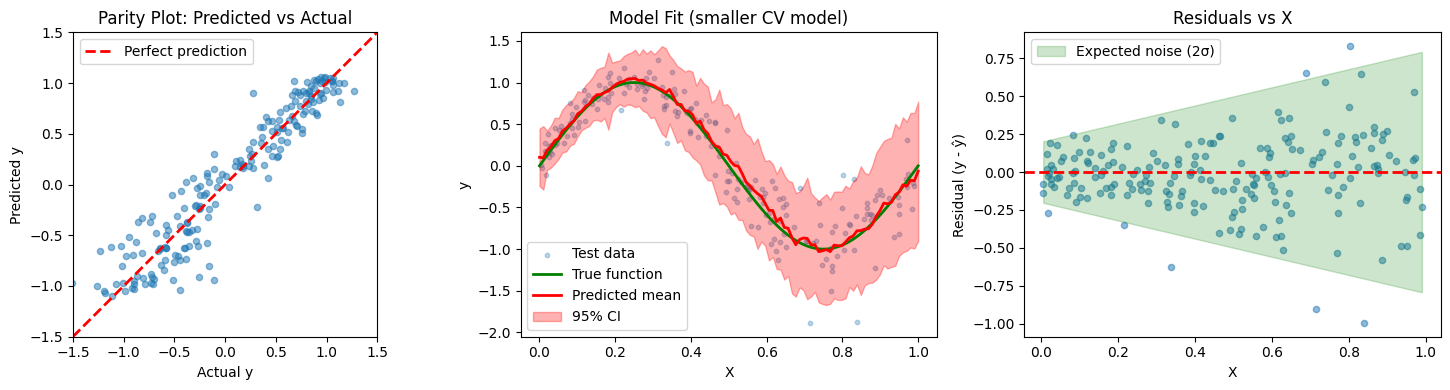

Test MSE: 0.0590
Test RMSE: 0.2429
Expected noise std (avg): 0.2410

The MSE is largely explained by the irreducible noise in the data!


In [14]:
# Visualize what the CV model actually does
# Fit a fresh model on train data and evaluate on test
model_viz = NFlowsRegressor(
    num_layers=3, hidden_features=32, max_epochs=100, patience=15, verbose=False, random_state=42
)
model_viz.fit(X_train, y_train)

# Get predictions with uncertainty
n_posterior = 100
y_samples_viz = np.array([model_viz.predict(X_test, n_samples=1) for _ in range(n_posterior)])
y_pred_mean = y_samples_viz.mean(axis=0)
y_pred_std = y_samples_viz.std(axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Parity plot (predicted vs actual)
axes[0].scatter(y_test, y_pred_mean, alpha=0.5, s=20)
axes[0].plot([-1.5, 1.5], [-1.5, 1.5], "r--", linewidth=2, label="Perfect prediction")
axes[0].set_xlabel("Actual y")
axes[0].set_ylabel("Predicted y")
axes[0].set_title("Parity Plot: Predicted vs Actual")
axes[0].legend()
axes[0].set_aspect("equal")
axes[0].set_xlim(-1.5, 1.5)
axes[0].set_ylim(-1.5, 1.5)

# 2. Predictions on the function with uncertainty bands
X_plot_viz = np.linspace(0, 1, 100).reshape(-1, 1)
y_samples_plot = np.array([model_viz.predict(X_plot_viz, n_samples=1) for _ in range(n_posterior)])
y_plot_mean = y_samples_plot.mean(axis=0)
y_plot_std = y_samples_plot.std(axis=0)
y_true_plot = np.sin(2 * np.pi * X_plot_viz).ravel()

axes[1].scatter(X_test, y_test, alpha=0.3, s=10, label="Test data")
axes[1].plot(X_plot_viz, y_true_plot, "g-", linewidth=2, label="True function")
axes[1].plot(X_plot_viz, y_plot_mean, "r-", linewidth=2, label="Predicted mean")
axes[1].fill_between(
    X_plot_viz.ravel(),
    y_plot_mean - 2 * y_plot_std,
    y_plot_mean + 2 * y_plot_std,
    alpha=0.3,
    color="red",
    label="95% CI",
)
axes[1].set_xlabel("X")
axes[1].set_ylabel("y")
axes[1].set_title("Model Fit (smaller CV model)")
axes[1].legend()

# 3. Residuals vs X (to see if error structure matches heteroscedasticity)
residuals = y_test - y_pred_mean
axes[2].scatter(X_test, residuals, alpha=0.5, s=20)
axes[2].axhline(0, color="red", linestyle="--", linewidth=2)
# Show expected noise envelope
X_sorted = np.sort(X_test.ravel())
noise_envelope = 0.1 + 0.3 * X_sorted
axes[2].fill_between(
    X_sorted,
    -2 * noise_envelope,
    2 * noise_envelope,
    alpha=0.2,
    color="green",
    label="Expected noise (2σ)",
)
axes[2].set_xlabel("X")
axes[2].set_ylabel("Residual (y - ŷ)")
axes[2].set_title("Residuals vs X")
axes[2].legend()

plt.tight_layout()
plt.show()

# Summary statistics
print(f"Test MSE: {np.mean((y_test - y_pred_mean) ** 2):.4f}")
print(f"Test RMSE: {np.sqrt(np.mean((y_test - y_pred_mean) ** 2)):.4f}")
print(f"Expected noise std (avg): {np.mean(0.1 + 0.3 * X_test):.4f}")
print("\nThe MSE is largely explained by the irreducible noise in the data!")

### 5.2 Grid Search for Hyperparameter Tuning

In [15]:
param_grid = {"num_layers": [3, 5], "hidden_features": [32, 64], "num_bins": [4, 8]}

grid_search = GridSearchCV(
    NFlowsRegressor(max_epochs=100, patience=15, verbose=False, random_state=42),
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=1,
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.4f}")
print(f"Test score: {grid_search.best_estimator_.score(X_test, y_test):.4f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters: {'hidden_features': 32, 'num_bins': 4, 'num_layers': 3}
Best score: -0.1496
Test score: -0.0656


### 5.3 Pipelines

In [16]:
# Create a pipeline with preprocessing
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "flow",
            NFlowsRegressor(
                num_layers=5,
                hidden_features=64,
                max_epochs=200,
                patience=20,
                verbose=False,
                random_state=42,
            ),
        ),
    ]
)

pipeline.fit(X_train, y_train)
print(f"Pipeline test score: {pipeline.score(X_test, y_test):.4f}")

Pipeline test score: -0.0785


### 5.4 Using the Convenience Function

In [17]:
# Quick model creation with presets
quick_model = create_flow_regressor("medium", max_epochs=150, verbose=True, random_state=42)
quick_model.fit(X_train, y_train)
print(f"\nQuick model test score: {quick_model.score(X_test, y_test):.4f}")

Forward flow Epoch 50/150, Loss: 0.2885
Forward flow: Early stopping at epoch 57
Inverse flow Epoch 50/150, Loss: 0.4732
Inverse flow: Early stopping at epoch 51

Quick model test score: -0.0733


## Summary

The `NFlowsRegressor` provides:

1. **Forward inference**: `model.predict(X)` - predict y given X
2. **Inverse inference**: `model.inverse(y)` - find X given y
3. **Uncertainty quantification**: `model.sample_posterior(X)` - full distributions
4. **Sklearn compatibility**: cross-validation, GridSearchCV, pipelines

**When to use:**
- Design optimization (find inputs for desired outputs)
- Inverse problems with uncertainty
- When outputs may have multiple valid inputs (multimodal posteriors)
- Regression requiring uncertainty quantification